In [1]:
#default_exp data_loading

In [32]:
# export
import pandas as pd
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn import model_selection

In [3]:
%matplotlib inline

In [4]:
# export
def map_class_to_taxon(mapping, class_id, taxon='Family'):
    return mapping.loc[class_id][taxon]


def parse_image(filename, image_size=224):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [image_size, image_size])
    return image

In [5]:
# export
DATA_DIR = os.path.join('..', 'data')


def get_metadata(data_dir=DATA_DIR):
    metadata_path = os.path.join(data_dir, 'PlantCLEF2019MasterTraining.csv')
    return pd.read_csv(metadata_path, sep=';')
    

In [6]:
metadata_df = get_metadata()

In [7]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434251 entries, 0 to 434250
Data columns (total 10 columns):
MediaId        434251 non-null object
YearInCLEF     434251 non-null object
LearnTag       434251 non-null object
ClassId        434251 non-null int64
Species        434251 non-null object
Genus          434251 non-null object
Family         434251 non-null object
Origin         434251 non-null object
OriginalUrl    434251 non-null object
BackupLink     434251 non-null object
dtypes: int64(1), object(9)
memory usage: 33.1+ MB


In [8]:
metadata_df.head()

,MediaId,YearInCLEF,LearnTag,ClassId,Species,Genus,Family,Origin,OriginalUrl,BackupLink
0,5c3e30f1706244e9f199d5a0c5a5ec00d1cbf473,PlantCLEF2019,Train,183350,Taralea oppositifolia Aubl.,Taralea,Leguminosae,microsoftimage,http://www.bing.com/cr?IG=E56D8ED3E44B4D6BB7E1...,http://otmedia.lirmm.fr/LifeCLEF/b/gu/183350/5...
1,83cead55f3be63d6fbe0c1e6c87ee2223c7a6e9b,PlantCLEF2019,Train,12254,Anacardium occidentale L.,Anacardium,Anacardiaceae,microsoftimage,http://www.bing.com/cr?IG=8DC6223C2EBC42F0A017...,http://otmedia.lirmm.fr/LifeCLEF/b/gu/12254/83...
2,1e2f13d4773a8feafb68930117d1773ba712aa79,PlantCLEF2019,Train,263952,Ischaemum muticum L.,Ischaemum,Poaceae,microsoftimage,http://www.bing.com/cr?IG=DDA2A184733547F09081...,http://otmedia.lirmm.fr/LifeCLEF/b/gu/263952/1...
3,5e49ad7196984b90ad1c5f8648fe77803b40a75b,PlantCLEF2019,Train,158247,Mezilaurus decurrens (Ducke) Kosterm.,Mezilaurus,Lauraceae,googleimage,https://encrypted-tbn0.gstatic.com/images?q=tb...,http://otmedia.lirmm.fr/LifeCLEF/b/gu/158247/5...
4,109240430bfcca5a7c3eec0fc6a165ad242e7d55,PlantCLEF2019,Train,24496,Tabernaemontana grandiflora Jacq.,Tabernaemontana,Apocynaceae,microsoftimage,https://www.bing.com/cr?IG=836545099C7F450589B...,http://otmedia.lirmm.fr/LifeCLEF/b/gu/24496/10...


In [9]:
family_counts = metadata_df['Family'].value_counts()
family_counts[family_counts > 1000].sum()

388594

In [10]:
metadata_df['Family'].value_counts()

Orchidaceae         37703
Leguminosae         30122
Poaceae             26335
Rubiaceae           16441
Malvaceae           14765
                    ...  
Martyniaceae            7
Anisophylleaceae        7
Canellaceae             7
Metaxyaceae             2
Ranunculaceae           1
Name: Family, Length: 248, dtype: int64

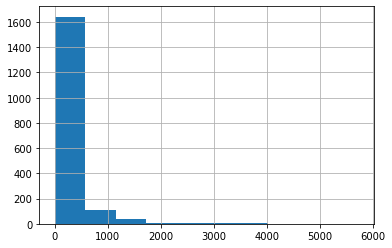

In [11]:
metadata_df['Genus'].value_counts().hist()

In [12]:
metadata_df['ClassId'].unique().shape

(10000,)

In [13]:
metadata_df['Species'].value_counts()[-2000:]

Hyptis microphylla Pohl ex Benth.                      6
Gunnera silvioana L.E.Mora                             6
Fridericia cinerea (Bureau ex K.Schum.) L.G.Lohmann    6
Rhynchospora ayangannensis M.T.Strong                  6
Tetrapterys styloptera A.Juss.                         6
                                                      ..
Bacopa bacopoides (Benth.) Pulle                       1
Pouteria minima T.D.Penn.                              1
Mollia tomentosa Spruce ex Benth.                      1
Dalechampia triphylla Lam.                             1
Oserya perpusilla (Went) P.Royen                       1
Name: Species, Length: 2000, dtype: int64

In [14]:
!ls data/images/data/101969

ls: cannot access 'data/images/data/101969': No such file or directory


In [15]:
# export
train_dir = os.path.join(DATA_DIR, 'images_train/data')

In [16]:
# export

def prepare_classification_metadata(metadata_df, target_col, basepath):
    def make_filename_from_parts(parts):
        return os.path.join(*(basepath, *map(str, parts))) + '.jpg'
    filename = 'MediaId'
    df = pd.DataFrame({'class': metadata_df[target_col], 'name': metadata_df[filename]})
    df['filename'] = metadata_df[['ClassId', filename]].agg(make_filename_from_parts, axis=1)
    return df

In [41]:
%%time

raw_classification_metadata_df = prepare_classification_metadata(metadata_df, 'Family', train_dir)

CPU times: user 42 s, sys: 396 ms, total: 42.4 s
Wall time: 42.4 s


## Number of classes

In [42]:
raw_classification_metadata_df['class'].unique().shape

(248,)

## Number of classes with more than 1000 examples

In [60]:
# export
def get_classification_metadata_df(raw_metadata_df):
    class_counts = raw_classification_metadata_df['class'].value_counts()
    big_enough_classes = class_counts.index[class_counts > 1000]
    return raw_classification_metadata_df[raw_classification_metadata_df['class'].isin(big_enough_classes)]

In [60]:
classification_metadata_df = get_classification_metadata_df(raw_classification_metadata_df)
classification_metadata_df.shape

(388594, 3)

In [64]:
train_classification_metadata_df, test_classification_metadata_df = model_selection.train_test_split(classification_metadata_df, test_size=10000, random_state=0)

In [65]:
sample_classification_df = prepare_classification_metadata(sample_metadata_df, 'Species', train_dir)

In [66]:
image_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, horizontal_flip=True)

sample_image_iterator = image_gen.flow_from_dataframe(sample_classification_df, target_size=(224, 224))

n_classes = len(sample_image_iterator.class_indices)

Found 1000 validated image filenames belonging to 867 classes.


In [67]:
batch = next(sample_image_iterator)

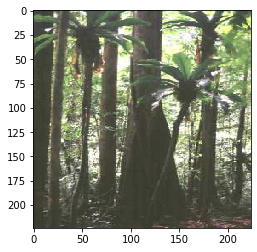

In [68]:
plt.imshow(batch[0][1]);

### This part will be used in script mode

In [ ]:
#export
train_csv_path = os.path.join(DATA_DIR, 'train_metadata.csv')
test_csv_path = os.path.join(DATA_DIR, 'test_metadata.csv')
test_size = 10000
target_class = 'Family'


if __name__ == '__main__':
    metadata_df = get_metadata()
    raw_classification_metadata_df = prepare_classification_metadata(metadata_df, 'Family', train_dir)
    classification_metadata_df = get_classification_metadata_df(raw_classification_metadata_df)
    train_classification_metadata_df, test_classification_metadata_df = model_selection.train_test_split(classification_metadata_df, test_size=test_size, random_state=0)
    if os.path.exists(train_csv_path) or os.path.exists(test_csv_path):
        raise ValueError("some metadata file already exists, exiting")
    else:
        train_classification_metadata_df.to_csv(train_csv_path)
        test_classification_metadata_df.to_csv(test_csv_path)